<details>
   <summary>Metadata</summary> 
    title: "E-TRAINEE Machine learning on point clouds with Python"<br>
    description: "This is the fifth theme within the 3D/4D Geographic Point Cloud Time Series Analysis module."<br>
    dateCreated: 2022-06-15 <br>
    author: Lukas Winiwarter <br>
    contributors: Katharina Anders, Bernhard Höfle<br>
    estimatedTime: 1.5 hrs <br>
</details>

# Machine learning on point clouds with Python
In this course, machine learning is introduced and applied to point cloud data. We use Python to experiment with different machine learning methods and see how **regression** and **classification** methods can be used with point clouds to identify changes. The main concepts of **supervised** and **unsupervised** classification are discussed.

For data handling (reading and loading of point clouds), we will be reusing code from the second theme: [Programming for point cloud analysis with Python](../02_pointcloud_programming_python/02_pointcloud_programming_python.ipynb). If you struggle with reading files, please revisit this theme.


The objective in this theme is to:
1) Use classification on point cloud data to separate the dataset into semantically meaningful segments
2) Derive point cloud distances (cf. Theme 3: [3D change detection and analysis](../03_3d_change_analysis/03_3d_change_analysis.ipynb))
3) Train a regression method to predict distances from one single epoch for us (i.e., predicting where how much change will happen)

In this theme, you will learn about:
* <a href="#creating-feature-spaces-based-on-local-neighborhoods">Creating feature spaces based on local neighborhoods</a>
* <a href="#training-a-supervised-classifier">Training a supervised classifier</a>
* <a href="#support-vector-machines">Support Vector Machines</a>
* <a href="#scaling">Scaling</a>
* <a href="#evaluation-of-supervised-classifiers">Evaluation of supervised classifiers</a>
* <a href="#random-forest">Random forests</a>
* <a href="#unsupervised-classification">Unsupervised classification</a>
* <a href="#regression-models">Regression models</a>
* <a href="#a-few-words-on-deep-learning">A few words on Deep Learning</a>


After finishing this theme you will be able to:

 * derive a feature vector from the local neighbourhood of a point cloud
 * apply supervised (SVM, Random Forest) and unsupervised (kMeans) classification methods
 * apply supervised regression methods (Random Forest Regression)

## Requirements for this lesson

To perform the exercises in this theme, some specific (and common) Python libraries are required. Set up the Python environment following the [course instructions in the software section](../../software/software_python.md).

_Alternatively, to install only packages needed in this exercise, use:_

`mamba install -c conda-forge polyscope numpy matplotlib ipyleaflet laspy pyproj scikit-learn tqdm shapely`

`python -m pip install py4dgeo`

## Data

The data used in this exercise are two point clouds of the *Hellstugubrean* glacier in the *Jotunheimen nasjonalpark*, Norway [61.5759° N, 8.4459° E](https://www.norgeskart.no/#!?project=norgeskart&layers=1002&zoom=11&lat=6844452.67&lon=152372.10&markerLat=6844452.666682822&markerLon=152372.10344584702&p=Koordinater&showSelection=false).
Data is provided by the *Norwegian Mapping Authority* under the **CC BY 4.0** License: ©Kartverket. For more details, see [here](https://www.kartverket.no/en/api-and-data/terms-of-use). The data was downloaded from [Høydedata](https://hoydedata.no/LaserInnsyn/) and cropped to the area of interest.

Find the data files in the directory `hellstugubrean` of the course data repository.

We use two acquisitions, an airborne laser scanning point cloud from 2009 with an average point density of 0.3 $pts/m^2$ and a dense image matching (DIM, i.e. photogrammetry-based) point cloud from 2017 with an average point density of 4 $pts/m^2$. Let us take a look at the data using polyscope:

In [1]:
import polyscope as ps
import numpy as np

# add the script assets folder to the path, so that we can import the functions created there
import sys
from pathlib import Path
sys.path.insert(0, str((Path.cwd() / ".." / ".." / "assets" / "python_functions").resolve()))

# import point cloud functions
import pointcloud_functions as pcfuncs

DATA_PATH = 'path-to-data'

# check if the specified data path exists
import os
if not os.path.isdir(DATA_PATH):
    print(f'ERROR: {DATA_PATH} does not exist')
    print('Please specify the correct path to the data directory by replacing <path-to-data> above.')

# read data, but only every 100th point (for quick visualisation)
data_2009 = pcfuncs.read_las(DATA_PATH + "/hellstugubrean_2009.las", use_every=100, get_attributes=True)
data_2017 = pcfuncs.read_las(DATA_PATH + "/hellstugubrean_2017.las", use_every=100, get_attributes=True)

In [2]:
# start up polyscope
ps.init()
pc_2009 = ps.register_point_cloud("point cloud 2009", data_2009[0])
# for the ALS point cloud, add the Intensity as a scalar value
pc_2009.add_scalar_quantity('Intensity', data_2009[1]["intensity"])
pc_2017 = ps.register_point_cloud("point cloud 2017", data_2017[0])
# for the DIM point cloud, add RGB attributes. We need to provide them as a Nx3 array, so we stack red, green and blue together.
# furthermore, they need to be values between 0 and 1, but are "unsigned integer with 16 bit", i.e. values between 0 and 65535.
pc_2017.add_color_quantity('RGB', np.array([data_2017[1]["red"], data_2017[1]["green"], data_2017[1]["blue"]]).T / 65535)
ps.set_up_dir("z_up")
ps.show()

You can see that the 2009 point cloud is higher than the 2017 point cloud in two areas. These can be attributed to significan mass loss of the glacier over the course of these 8 years (remember also your [change detection results with the same data in Theme 2](../02_pointcloud_programming_python/02_pointcloud_programming_python.ipynb)). If you display either the intensity values of the 2009 point cloud or the RGB values of the 2017 point cloud (use the menu on the left side), you will also see the glacier ice in contrast to the bare rock surrounding it.

<a id='creating-feature-spaces-based-on-local-neighborhoods'></a>
## Creating feature spaces based on local neighbourhoods
Before we can start separating the glacier surfaces from the bare rock around them, we need to create a so-called *feature space* for the classification. As we want to assign each ALS/DIM point to either glacier or rock, we also calculate the features for each point.

The feature space is given as an $n$-dimensional vector. This is the input data that will then be used to infer the classification. Mathematically, the machine learning method is a function $f(x)$ that operates on the feature vector ($x$) and outputs a class label $y$. In our case, the class label $y=0$ will refer to rock surfaces, while $y=1$ will refer to glacier surfaces:

$y = f(x)$,

$x \in \mathbb{R}^n$,

$y \in \{0... rock, 1... glacier\}$

The features we want to derive for the feature vector should therefore **describe the point and its local properties**. As we don't have laser intensity data for the DIM dataset, and no RGB information for the ALS dataset, we cannot simply use these values, if we want to create a classifier that can be applied to both datasets. Instead, we will rely on **geometric** information that is contained in the point cloud by the local neighbours for each point.

The structure of the local neighbourhood can be described by the **structure tensor**, a 3x3-Matrix derived from the XYZ-coordinates of the points in the neighbourhood of a query point. From this tensor, we can derive normalized values like the *planarity*, the *linearity* and the *omnivariance*, and metric values like the *roughness* and the *slope*. We will derive these values for each point in the ALS point cloud first and visualize them - both as point cloud attributes and in the feature space.
The formulas for *planarity*, *linearity* and *omnivariance* are taken from [Weinmann et al. (2013)](http://recherche.ign.fr/labos/matis/pdf/articles_conf/2013/LS2013-39-2_finalpaper.pdf).
First, let us create a function to calculate these features for a single point and its neighbours:

In [3]:
def create_feature_vector(neighbour_points):
    # structure tensor
    struct_tensor = np.cov(neighbour_points.T)
    # eigenvalue decomposition
    eigvals, eigvec = np.linalg.eigh(struct_tensor)
    l3, l2, l1 = eigvals

    # find eigenvector to smallest eigenvalue = normal vector to best fitting plane
    normalvector = eigvec[:, 0]
    # flip so that it always points "upwards"
    if normalvector[2] < 0:
        normalvector *= -1

    # feature calculation
    planarity = (l2-l3)/l1
    linearity = (l1-l2)/l1
    omnivariance = (l1*l2*l3)**(1./3)
    roughness = l3
    slope = np.arctan2(np.linalg.norm(normalvector[:2]), normalvector[2])

    return np.array([planarity,
                     linearity,
                     omnivariance,
                     roughness,
                     slope])

Now we will query the neighbours of every point and subsequently call the function to create the feature vector. As we have a lot of points and neighbours, this will take some time, even if we use a spatial index for the neighbourhood query.

In [4]:
points_2009 = pcfuncs.read_las(DATA_PATH + "/hellstugubrean_2009.las")
from scipy import spatial
print("Building KD tree...")
tree_2009 = spatial.KDTree(points_2009)
print("Querying neighbours...")
neighbours = tree_2009.query_ball_tree(tree_2009, r=5)

feature_array = np.empty((points_2009.shape[0], 5), dtype=np.float32)
print("Calculating features...")
from tqdm import tqdm
for pix, point_neighbours in tqdm(enumerate(neighbours), unit='pts', total=points_2009.shape[0]):
    curr_neighbours = points_2009[point_neighbours]
    curr_features = create_feature_vector(curr_neighbours)
    feature_array[pix, :] = curr_features

Building KD tree...
Querying neighbours...
Calculating features...


  1%|          | 8621/1694840 [00:06<07:08, 3938.63pts/s]C:\Users\Katharina\AppData\Local\Temp\ipykernel_7548\3722135646.py:15: RuntimeWarning: invalid value encountered in scalar divide
  planarity = (l2-l3)/l1
C:\Users\Katharina\AppData\Local\Temp\ipykernel_7548\3722135646.py:16: RuntimeWarning: invalid value encountered in scalar divide
  linearity = (l1-l2)/l1
  1%|          | 11679/1694840 [00:07<08:43, 3214.33pts/s]C:\Users\Katharina\AppData\Local\Temp\ipykernel_7548\3722135646.py:17: RuntimeWarning: invalid value encountered in scalar power
  omnivariance = (l1*l2*l3)**(1./3)
100%|██████████| 1694840/1694840 [07:09<00:00, 3945.06pts/s]


In [5]:
ps.init()
pc_2009 = ps.register_point_cloud("point cloud 2009", points_2009)

pc_2009.add_scalar_quantity('Planarity', feature_array[:, 0])
pc_2009.add_scalar_quantity('Linearity', feature_array[:, 1])
pc_2009.add_scalar_quantity('Omnivariance', feature_array[:, 2])
pc_2009.add_scalar_quantity('Roughness', feature_array[:, 3])
pc_2009.add_scalar_quantity('Slope', feature_array[:, 4])
ps.set_up_dir("z_up")
ps.show()

In the visualization, we can see that some features (*Omnivariance*, *Roughness*) outline the glacier well, but a simple thresholding would not suffice. We can also plot the points in a 2D slice (as a histogram) through the feature space using these variables as dimensions:

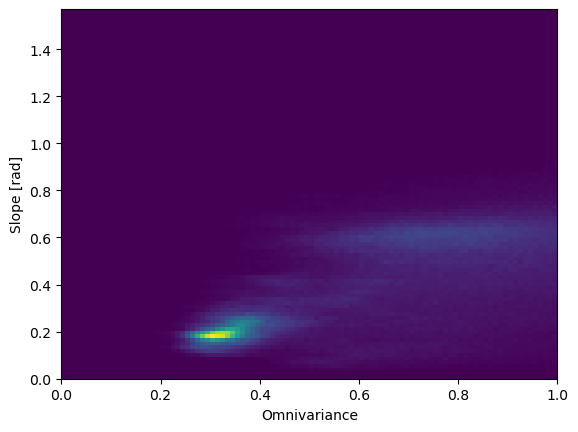

In [6]:
import matplotlib.pyplot as plt

plt.hist2d(feature_array[:, 2], feature_array[:, 4], bins=100, range=[[0, 1], [0, 3.14/2]])
plt.xlabel("Omnivariance")
plt.ylabel("Slope [rad]")
plt.show()

<a id='training-a-supervised-classifier'></a>
## Training a supervised classifier

We have seen that the separation of the glacial areas from the rock surface is non-trivial, if we don't include intensity or RGB information. However, we (as human operators) can define areas where we know the surface type, and use that to teach the computer how to interpret the feature space.
For this, we need so-called *training data*. We will now create training data by drawing polygons on a map that shows the glacier outline (OpenStreetMap).

We use `iypyleaflet` to display a map directly in the notebook. Use the upper "Create Polygon" button to create polygons for the glacier training area (light blue) and the lower "Create Polygon" button for the rock training area (dark blue). Two examples have been added for you, which you can adapt freely. We use the color of the polygons to separate them in the next code block.

In [7]:
from ipyleaflet import Map, Rectangle, DrawControl

from pyproj import Transformer
t_utm_to_wgs = Transformer.from_crs(25832, 4326)
t_wgs_to_utm = Transformer.from_crs(4326, 25832)

draw_control1 = DrawControl()
draw_control1.polyline = {}
draw_control1.circlemarker = {}
draw_control1.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 1.0
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": False
}

draw_control1.data = [{'type': 'Feature',
  'properties': {'style': {'pane': 'overlayPane',
    'attribution': None,
    'bubblingMouseEvents': True,
    'fill': True,
    'smoothFactor': 1,
    'noClip': False,
    'stroke': True,
    'color': '#6be5c3',
    'weight': 4,
    'opacity': 0.5,
    'lineCap': 'round',
    'lineJoin': 'round',
    'dashArray': None,
    'dashOffset': None,
    'fillColor': '#6be5c3',
    'fillOpacity': 1,
    'fillRule': 'evenodd',
    'interactive': True,
    'clickable': True}},
  'geometry': {'type': 'Polygon',
   'coordinates': [[
       [ 8.443458056811993, 61.573158353361549 ], 
       [ 8.444874560126243, 61.574126167025533 ], 
       [ 8.447390936602142, 61.573880250022164 ], 
       [ 8.447774225734232, 61.572595103638051 ], 
       [ 8.44485789538137, 61.572301575079962 ], 
       [ 8.443458056811993, 61.573158353361549 ]
   ]]}},
        {'type': 'Feature',
  'properties': {'style': {'pane': 'overlayPane',
    'attribution': None,
    'bubblingMouseEvents': True,
    'fill': True,
    'smoothFactor': 1,
    'noClip': False,
    'stroke': True,
    'color': '#1515f1',
    'weight': 4,
    'opacity': 0.5,
    'lineCap': 'round',
    'lineJoin': 'round',
    'dashArray': None,
    'dashOffset': None,
    'fillColor': '#5115f1',
    'fillOpacity': 1,
    'fillRule': 'evenodd',
    'interactive': True,
    'clickable': True}},
  'geometry': {'type': 'Polygon',
   'coordinates': [[
       [ 8.450823874046085, 61.576712143890624 ], 
       [ 8.453556892205341, 61.577663982918892 ], 
       [ 8.456356569344091, 61.576426586484779 ], 
       [ 8.453323585777111, 61.57536365525263 ], 
       [ 8.451390475371786, 61.575062220361872 ], 
       [ 8.450823874046085, 61.576712143890624 ]
   ]]}}]

draw_control2 = DrawControl()
draw_control2.polyline = {}
draw_control2.circlemarker = {}
draw_control2.polygon = {
    "shapeOptions": {
        "fillColor": "#5115f1",
        "color": "#1515f1",
        "fillOpacity": 1.0
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": False
}

rectangle = Rectangle(bounds=(
t_utm_to_wgs.transform(np.min(points_2009[:, 0]), np.min(points_2009[:, 1])), t_utm_to_wgs.transform(np.max(points_2009[:, 0]), np.max(points_2009[:, 1]))
), fill_color='#3eab47', color="#225e27")

m = Map(center=(61.5759, 8.4459), zoom=13)
m.add_layer(rectangle)
m.add_control(draw_control1)
m.add_control(draw_control2)
m

Map(center=[61.5759, 8.4459], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [8]:
glacier_parts = []
rock_parts = []
for feature in draw_control1.data:
    if feature['properties']['style']['color'] == '#1515f1':
        rock_parts.append(feature['geometry']['coordinates'][0])
    else:
        glacier_parts.append(feature['geometry']['coordinates'][0])
print("Glacier:", glacier_parts)
print("Rock:", rock_parts)

Glacier: [[[8.443458056811993, 61.57315835336155], [8.444874560126243, 61.57412616702553], [8.447390936602142, 61.573880250022164], [8.447774225734232, 61.57259510363805], [8.44485789538137, 61.57230157507996], [8.443458056811993, 61.57315835336155]]]
Rock: [[[8.450823874046085, 61.576712143890624], [8.453556892205341, 61.57766398291889], [8.456356569344091, 61.57642658648478], [8.453323585777111, 61.57536365525263], [8.451390475371786, 61.57506222036187], [8.450823874046085, 61.576712143890624]]]


In [9]:
glacier_parts_utm = [[t_wgs_to_utm.transform(*part[::-1]) for part in poly] for poly in glacier_parts]

In [10]:
rock_parts_utm = [[t_wgs_to_utm.transform(*part[::-1]) for part in poly] for poly in rock_parts]

Now we have defined training areas and can visualize the feature distribution again - but this time, stratified for each class.
First, we select all the points within the respective polygons, then we create the 2D histograms on the subsets.

In [11]:
from shapely import geometry

glacier_polys = []
for glacier_part in glacier_parts_utm:
    line = geometry.LineString(glacier_part)
    polygon = geometry.Polygon(line)
    glacier_polys.append(polygon)
glacier = geometry.MultiPolygon(glacier_polys)
    
rock_polys = []
for rock_part in rock_parts_utm:
    line = geometry.LineString(rock_part)
    polygon = geometry.Polygon(line)
    rock_polys.append(polygon)
rock = geometry.MultiPolygon(rock_polys)



In [12]:
rock_idx = []
glacier_idx = []
for ptidx in tqdm(range(points_2009.shape[0])):
    point = geometry.Point(points_2009[ptidx, 0], points_2009[ptidx, 1])
    if glacier.contains(point):
        glacier_idx.append(ptidx)
    if rock.contains(point):
        rock_idx.append(ptidx)


100%|██████████| 1694840/1694840 [01:22<00:00, 20633.51it/s]


In [13]:
print(f"Dataset size:\n\tGlacier: {len(glacier_idx)} points\n\tRock: {len(rock_idx)} points")

Dataset size:
	Glacier: 40444 points
	Rock: 50576 points


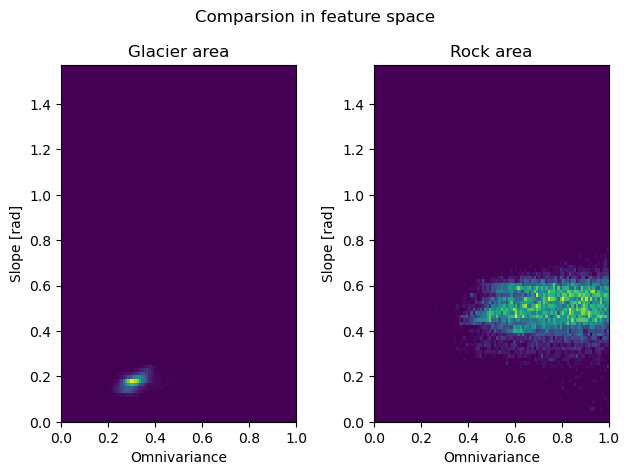

In [14]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparsion in feature space')
ax1.hist2d(feature_array[glacier_idx, 2], feature_array[glacier_idx, 4], bins=100, range=[[0, 1], [0, 3.14/2]])
ax1.set_xlabel('Omnivariance')
ax1.set_ylabel('Slope [rad]')
ax1.set_title('Glacier area')
ax2.hist2d(feature_array[rock_idx, 2], feature_array[rock_idx, 4], bins=100, range=[[0, 1], [0, 3.14/2]])
ax2.set_xlabel('Omnivariance')
ax2.set_ylabel('Slope [rad]')
ax2.set_title('Rock area')
plt.gcf().tight_layout()
plt.show()

Now we can get to training!

<a id='support-vector-machines'></a>
## Support Vector Machines
Support Vector Machines are a type of supervised machine learning method. Based on a set of training data, an optimal split between the different target classes is found.
This split can be represented by a (hyper)plane in feature space. With SVM, the plane is placed such that the orthogonal distance from the plane to the nearest training data point is maximised.

You can also imagine the plane to expand into the feature space. The optimal split is then found where this expansion is the largest.

In this primitive classifier, the hyperplane acts a a linear separator. However, many problems in real live require a non-linear split. To overcome this, SVMs can use *kernels* that transform the feature space before creating a separation hyperplane. Common *kernel functions* are radial base functions: polynomials depending on the radial distance from a point.

In the following, we will train & evaluate a linear SVM and an SVM employing such a radial base function, and see, how the feature space separation differs between the two.

Sometimes, some features are not available or cannot be computed (e.g., when a division by zero occurs). The classifier does not know how to deal with these values, and it is up to the user to clean the dataset beforehand. One option would be to remove all the data points where at least one of the features is invalid. Another option is to remove all the feature dimensions where this is the case. What we are going to do in our case is *impute* the invalid/missing values by calculating the mean value of all valid data points for each feature separately. Then, we set all the missing values to this mean value. To do so, we use a tool from `sklearn`, the `sklearn.impute.SimpleImputer`, which we "fit" on the training set (i.e., calculate the mean values based on the training set) and then apply it on both training and testing datasets. Generally, one could assume that the test dataset is not available at the time when the model is trained, so it is good practice to only use the training dataset up until the fit of the model has been done.

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Create a "label" vector that contains 0 for all rock training points and 1 for all glacier training points
labelled_features = np.concatenate([feature_array[rock_idx, :], feature_array[glacier_idx, :]])
label = np.zeros(shape=(labelled_features.shape[0]))
label[len(rock_idx):] = 1 # everything after the rock entries is glacier

# Split the dataset for train/test
X_train, X_test, y_train, y_test = train_test_split(labelled_features, label, test_size=0.8, random_state=42)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Try the linear SVM Classifier first:
linearSVM = SVC(kernel='linear')
linearSVM.fit(X_train, y_train)
scores = linearSVM.score(X_test, y_test)
print(f"Linear SVM: {scores}")

# Then try the rbf SVM Classifier. Uses a 3rd degree polynomial by default:
rbfSVM = SVC(kernel='rbf')
rbfSVM.fit(X_train, y_train)
scores = rbfSVM.score(X_test, y_test)
print(f"RBF SVM   : {scores}")



Linear SVM: 0.9996704021094265
RBF SVM   : 0.999780268072951


<a id='scaling'></a>
## Scaling
You might have noticed that when the SVM tries to maximize the band around the hyperplane before it "touches" the first data point of the training set, a euclidean distance is used. This euclidean distance across the feature space is a bit problematic. Why?
We include the value "slope" in the feature space. Above, we have calculated it to be in radians, but nothing is keeping us from converting it to degrees, or even percentages. However, if the distance to maximize is calculated based on that value, and it is mixed with other values of a different dimensionality (like planarity or linearity, which are unitless values between 0 and 1), we might get different results depending on the unit we choose. This is not ideal.

Therefore, for most machine learning applications, data needs to be *scaled* or *normalized* before training and testing. Typical options include:
- Transform the data so it fits in the $[0, 1[$ interval
- Transform the data so that it has mean $\mu=0$ and unit standard deviation $\sigma=1$.

`sklearn` provides us with tools to do exactly that: the `sklearn.preprocessing.MinMaxScaler` and the `sklearn.preprocessing.StandardScaler`. Depending on the data type, additional scalers are provided: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

Now, let's apply the `StandardScaler` using the RBF SVM classifier and compare results. Again, we fit the scaler on the training dataset only and apply it on both:

In [16]:
from sklearn.preprocessing import StandardScaler

# Train the scaler (i.e., estimate the transformation parameters from the training data)
scaler = StandardScaler()
scaler.fit(X_train)

# Then try the rbf SVM Classifier. Uses a 3rd degree polynomial by default:
rbfSVM = SVC(kernel='rbf')
rbfSVM.fit(scaler.transform(X_train), y_train)
scores = rbfSVM.score(scaler.transform(X_test), y_test)
print(f"RBF SVM (scaled): {scores}")


RBF SVM (scaled): 0.9999176005273567


Now the improvement might not seem like a lot, but keep in mind that an increase in accuracy from 0.9998 to 0.9999 represents a 50% reduction in incorrect estimations!

**Note:** your numbers might differ because of differently drawn training area polygons.

<a id='evaluation-of-supervised-classifiers'></a>
## Evaluation of supervised classifiers
So far, we have looked at a single score representing the quality of the estimation. However, we might also want to take a look at the final result. Let us run the full point cloud through the classifier and visualize it.

In [17]:
full_result = rbfSVM.predict(scaler.transform(imp.transform(feature_array[::100])))
print(f"{np.count_nonzero(full_result==1)/len(full_result)*100.:.2f}% of the points are predicted as glacier.")
ps.init()
pc_2009 = ps.register_point_cloud("point cloud 2009", points_2009[::100])
pc_2009.add_scalar_quantity('Predicted class', full_result)
ps.set_up_dir("z_up")
ps.show()

20.43% of the points are predicted as glacier.


<a id='random-forest'></a>
## Random forests
Random forests are a different supervised classification method. They rely on a set of binary trees (hence the term *forest*), which are trained using (a) random subsets of the training data points and (b) random subsets of the feature space dimensions.

In [18]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(scaler.transform(X_train), y_train)
scores = rfc.score(scaler.transform(X_test), y_test)
print(f"Random Forest (scaled): {scores}")


Random Forest (scaled): 1.0


18.23% of the points are predicted as glacier.


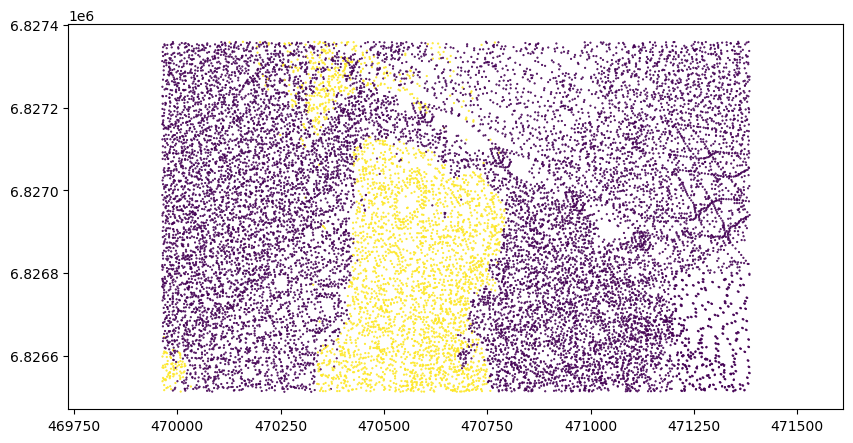

In [19]:
full_result = rfc.predict(scaler.transform(imp.transform(feature_array[::100])))
print(f"{np.count_nonzero(full_result==1)/len(full_result)*100.:.2f}% of the points are predicted as glacier.")
plt.figure(figsize=(10,5))
plt.scatter(points_2009[::100][:, 0], points_2009[::100][:, 1], c=full_result, s=0.3)
plt.axis('equal')
plt.show()
#ps.init()
#pc_2009 = ps.register_point_cloud("point cloud 2009", points_2009[::100])
#pc_2009.add_scalar_quantity('Predicted class', full_result)
#ps.set_up_dir("z_up")
#ps.show()

You can also adapt the parameters of these classifiers - e.g. the number of trees in the Random Forest. Check out the documentation for all options by writing `?RandomForestClassifier` in a code cell!

In [20]:
?RandomForestClassifier

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


<a id='unsupervised-classification'></a>
## Unsupervised classification

As you might have noticed in the plot of feature space above, the two classes form two clear clusters. In unsupervised classification, we make use of this and try to assign each data point to a cluster. Depending on the algorithm used, we may need to supply a number of clusters we want to extract (e.g. kMeans), or define how much two data points have to be separated by to form a new cluster (e.g. DBSCAN). As we know that we want to find two clusters in this dataset, we can use kMeans with $k=2$. Let's give it a try and see what happens!

Note that this works completely without the training labels. The algorithm therefore also does not know which result id is which - the glacier, or the rocks!

c:\Users\Katharina\.conda\envs\etrainee\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


18.23% of the points are predicted as 'Cluster A'.


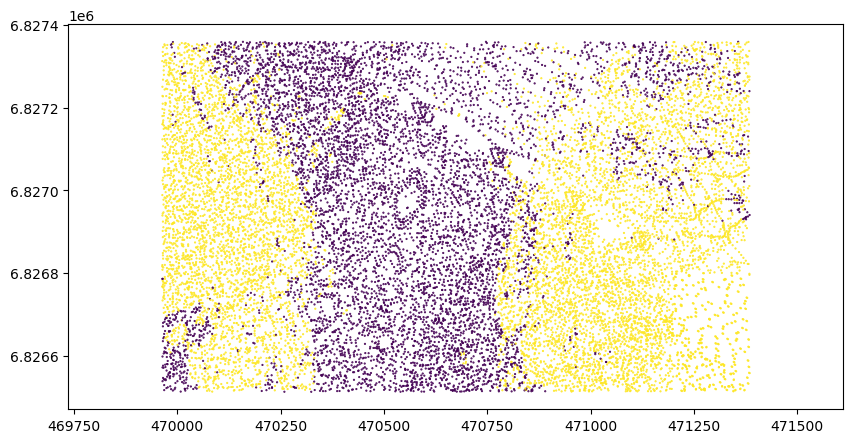

In [21]:
from sklearn.cluster import KMeans

feature_subset = feature_array[::100][:, [2,4]]

imp_sub = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_sub = imp.fit(feature_subset)
scaler_sub = StandardScaler()
scaler_sub.fit(feature_subset)

km = KMeans(n_clusters=2)

km.fit(scaler_sub.transform(imp_sub.transform(feature_subset)))
predicted_clusters = km.labels_

print(f"{np.count_nonzero(full_result==1)/len(full_result)*100.:.2f}% of the points are predicted as 'Cluster A'.")
plt.figure(figsize=(10,5))
plt.scatter(points_2009[::100][:, 0], points_2009[::100][:, 1], c=predicted_clusters, s=0.3)
plt.axis('equal')
plt.show()



What happens if you set $k=3$? Can you discover a third cluster/class present in the dataset, or do the results just get noisy?

In the end, with unsupervised methods, it is down to the user (*you!*) to make sense of the clusters the algorithm outputs.

<a id='regression-models'></a>
## Regression models
By now you are probably wondering what we loaded the second dataset in for. As the datasets are from different years, the change in surface topography (i.e., mainly retreat of the *Hellstugubrean* glacier) can be quantified. Let us first do that using the M3C2 point cloud distance metric you have learned about in [Theme 3](../03_3d_change_analysis/03_3d_change_analysis.ipynb):

In [22]:
import py4dgeo

# let's read the full datasets
data_2009 = pcfuncs.read_las(DATA_PATH + "/hellstugubrean_2009.las", get_attributes=True)
data_2017 = pcfuncs.read_las(DATA_PATH + "/hellstugubrean_2017.las", get_attributes=True)
points_2009 = data_2009[0]
points_2017 = data_2017[0]

epoch1 = py4dgeo.Epoch(points_2009)
epoch2 = py4dgeo.Epoch(points_2017)
corepoints = points_2009[::100, :]

m3c2 = py4dgeo.M3C2(
    epochs=(epoch1, epoch2),
    corepoints=corepoints,
    cyl_radii=(30.0,),
    normal_radii=(15.0,),
    max_distance=50.0
)
distances, uncertainties = m3c2.run()

[2023-03-29 20:49:16][INFO] Building KDTree structure with leaf parameter 10
[2023-03-29 20:49:17][INFO] Building KDTree structure with leaf parameter 10


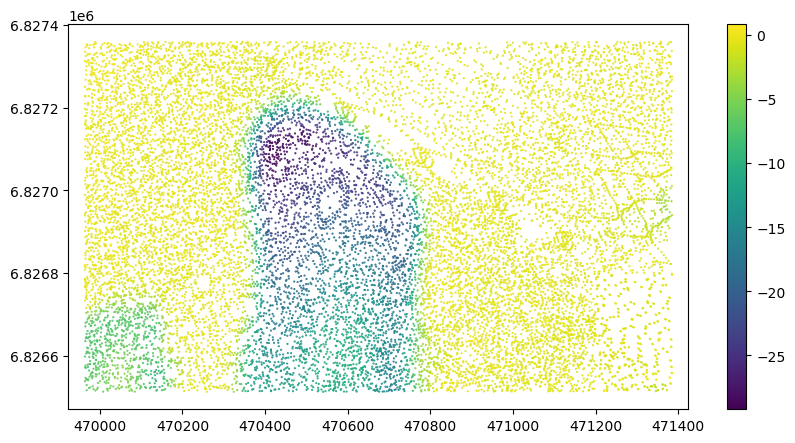

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(corepoints[:, 0], corepoints[:, 1], c=distances, s=0.3)
plt.axis('equal')
plt.colorbar()
plt.show()

You can see changes up to 25m where the glacier has retreated. We want to train a machine learning model to predict these changes from a single epoch, i.e., predict how much change occurs over the period of 8 years. For this, we will again define a feature space. As the surface change is dependant on the altitude, we will consider the Z coordinate of the points as one input feature. Additionaly, we will calculate roughness, slope and aspect angles and planarity. For this, we define a function as before:

In [24]:
def create_feature_vector(neighbour_points):
    # structure tensor
    struct_tensor = np.cov(neighbour_points.T)
    # eigenvalue decomposition
    eigvals, eigvec = np.linalg.eigh(struct_tensor)
    l3, l2, l1 = eigvals

    # find eigenvector to smallest eigenvalue = normal vector to best fitting plane
    normalvector = eigvec[:, 0]
    # flip so that it always points "upwards"
    if normalvector[2] < 0:
        normalvector *= -1

    # feature calculation
    planarity = (l2-l3)/l1
    roughness = l3
    slope = np.arctan2(np.linalg.norm(normalvector[:2]), normalvector[2])
    aspect = np.arctan2(normalvector[0], normalvector[1])

    return np.array([planarity,
                     roughness,
                     slope,
                     aspect]), normalvector

In regression tasks, we want to predict a scalar (or vector) quantity for each data point instead of a class label. We will explore the **Random Forest Regression**, which works similar to the Random forest we used for classification. Instead of predicting a class label, each tree in the random forest will give a scalar value. The result of the random forest is then the average of these scalar values.

As in the classification, we need some way of describing the data that we can use as input to the algorithm, i.e., the feature vector. Since we know the M3C2 distance (our regression *target*) only for a subset of the full point cloud (the *corepoints*), we create a feature vector for these points only. As we want to use the full information of the 3D point cloud, we query the neighbours from the full point cloud, though.

To give the algorithm even more information, we also add the z-Coordinate of the points as a feature. If you want to see how it performs without the z-coordinate, try changing the last line to set the final feature to a constant value (e.g., 0) - then, the information coming from this feature is none.

In [25]:
# first calculate the features for all core points (where we calculated an M3C2 distance), based on the neighbourhood 
# of the full point cloud 
from scipy import spatial
print("Building KD tree...")
tree_2009 = spatial.KDTree(points_2009)
corepoints_tree = spatial.KDTree(corepoints)
print("Querying neighbours...")
neighbours = corepoints_tree.query_ball_tree(tree_2009, r=5)

feature_array = np.empty((corepoints.shape[0], 5), dtype=np.float32)
print("Calculating features...")
from tqdm import tqdm
for pix, point_neighbours in tqdm(enumerate(neighbours), unit='pts', total=corepoints.shape[0]):
    curr_neighbours = points_2009[point_neighbours]
    curr_features, _ = create_feature_vector(curr_neighbours)
    feature_array[pix, :4] = curr_features
    feature_array[pix, -1] = corepoints[pix, 2]  # add z-coordinate as feature



Building KD tree...
Querying neighbours...
Calculating features...


100%|██████████| 16949/16949 [00:03<00:00, 4814.14pts/s]


We now load the random forest regressor class from the `sklearn` package, initialize it with a maximum tree depth of 15 and a random state (to ensure reproducible results). With the `.fit`-method, we can pass the feature array and the corresponding regression target to train the regressor.

As an example, we can print the prediction of the M3C2 distance for a feauture vector of $\vec{f} = \left( 0, 0, 0, 0\right)^T$

In [26]:

from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=15, random_state=0)
regr.fit(feature_array, distances)
print(regr)
print(regr.predict([[0, 0, 0, 0, 0]]))

RandomForestRegressor(max_depth=15, random_state=0)
[-0.6293358]


Now let us predict the actual M3C2 distances using the point cloud features and plot them. We can also plot the differences to the input data.

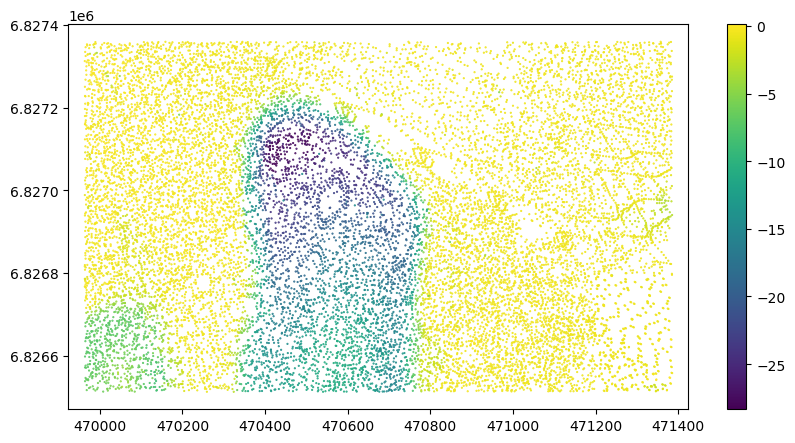

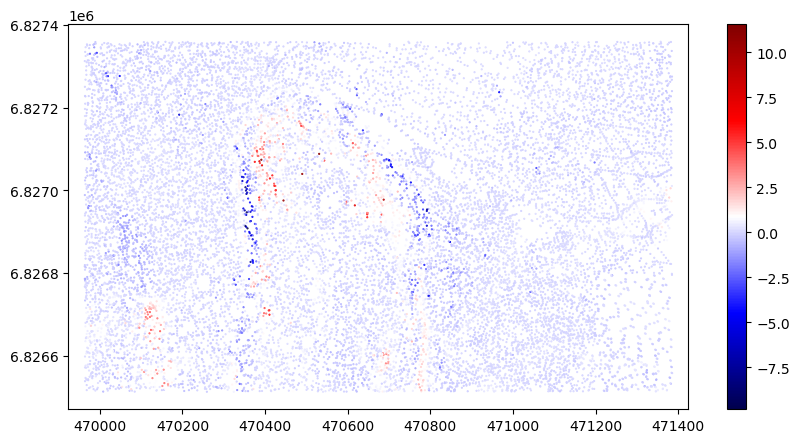

In [27]:
pred_dists = regr.predict(feature_array)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(corepoints[:, 0], corepoints[:, 1], c=pred_dists, s=0.3)
plt.axis('equal')
plt.colorbar()
plt.show()

import matplotlib.cm as cm
plt.figure(figsize=(10,5))
plt.scatter(corepoints[:, 0], corepoints[:, 1], c=pred_dists - distances, s=0.3, cmap=cm.seismic)
plt.axis('equal')
plt.colorbar()
plt.show()

As we can see, the prediction works quite well on the main glacier body and on the rocks around it. The largest errors >5 m appear at the edge of the glacier, where change on the inside of the glacier is overestimated (red), and it is underestimated on the outside (blue). 

Now, we can use this information to evaluate the quality of the estimation and compare it, e.g., to a regressor that does not have the z-coordinate information in its feature array. However, note that we trained the regressor on the full dataset, so here we are actually evaluating the *training* error. A more realistic and correct estimate of how the method would perform on previously unseen data would be to - as in the classification example - separate training and test data. As the M3C2 distance is subject to spatial autocorrelation (owing to - at least - the search radius for M3C2), a spatial split of the data would be the cleanest solution in this case.


Finally, let us predict the state of the glacier from the newer dataset (2017). As we have trained on the difference from 2009 to 2017, this can be seen as a very simple prediction on how the glacier looks like in 2025.
First, we have to calculate the feature vector for points in the 2017 dataset.

In [28]:
from scipy import spatial
print("Building KD tree...")
tree_2017 = spatial.KDTree(points_2017)
corepoints_2017 = points_2017[::300,:]
corepoints_2017_tree = spatial.KDTree(corepoints_2017)  # only use every 100th point
print("Querying neighbours...")
neighbours = corepoints_2017_tree.query_ball_tree(tree_2017, r=5)

feature_array = np.empty((corepoints_2017.shape[0], 5), dtype=np.float32)
normalvectors  = np.empty((corepoints_2017.shape[0], 3), dtype=np.float32)
print("Calculating features...")
from tqdm import tqdm
for pix, point_neighbours in tqdm(enumerate(neighbours), unit='pts', total=corepoints_2017.shape[0]):
    curr_neighbours = points_2017[point_neighbours]
    curr_features, normalvector = create_feature_vector(curr_neighbours)
    feature_array[pix, :4] = curr_features
    feature_array[pix, -1] = corepoints_2017[pix, 2]  # add z-coordinate as feature
    normalvectors[pix, :] = normalvector  # we will need this later for the prediction

Building KD tree...
Querying neighbours...
Calculating features...


100%|██████████| 20191/20191 [00:04<00:00, 4688.71pts/s]


Now we can run this on the already trained regressor and visualize the results:

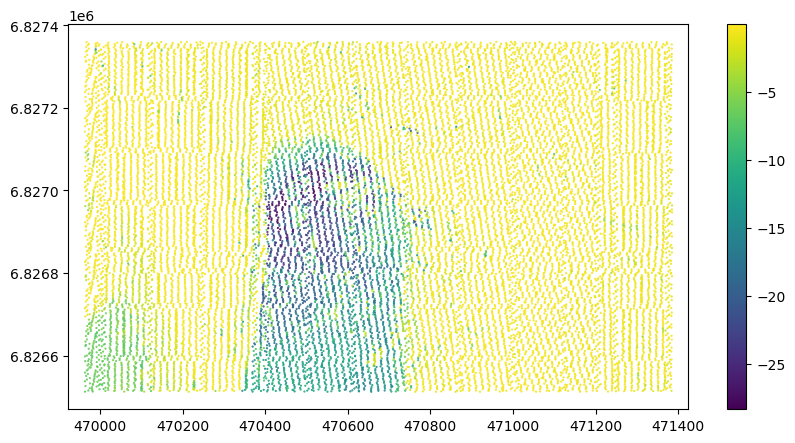

In [29]:
pred_dists = regr.predict(feature_array)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(corepoints_2017[:, 0], corepoints_2017[:, 1], c=pred_dists, s=0.3)
plt.axis('equal')
plt.colorbar()
plt.show()

We do not have data to validate this plot, but we can check for plausibility. What are the main observations you can make here?

Can you find out how much more the glacier is predicted to retreat in the years 2017-2025? Does it fit with the real observations found here:
http://glacier.nve.no/Glacier/viewer/CI/en/nve/ClimateIndicatorInfo/2768?name=Hellstugubreen
?

Finally, let us convert this prediction back into a 3D point cloud. We use the core point's normal vectors to displace them by the predicted distance and load the result into a 3D viewer.

In [30]:
points_2025 = corepoints_2017 + normalvectors * pred_dists[:, np.newaxis]  # newaxis needed to make dimensions fit

ps.init()
pc_2009 = ps.register_point_cloud("point cloud 2009", points_2009[::100])
pc_2017 = ps.register_point_cloud("point cloud 2017", corepoints_2017)
pc_2025 = ps.register_point_cloud("point cloud 2025", points_2025)
ps.set_up_dir("z_up")
ps.show()

You can see how the 2025 prediction shows further glacier retreat. Do note, however, that this is not a very elaborate prediction, but rather a simple machine learning example. You can e.g. see some artifacts due to the rectangular data format of the 2017 point cloud in the predictions.

<a id='a-few-words-on-deep-learning'></a>
## A few words on Deep Learning
You probably have heard about Deep Learning in a machine learning context. Deep Learning is a subset of machine learning that uses mathematical models of nervous cells (called neurons) to imitate brain function. In the last decade, Deep Learning has become the state-of-the-art in most machine learning disciplines.

The main advantage of Deep Learning over other machine learning algorithms is the so-called **representation learning**. Here, the user (you!) doesn't have to come up with their own features describing the data, but it is learned from the data itself. The algorithm therefore learns how to represent the data in a way that then allows easy classification or regression.

For point clouds, the neighbourhood information can be included as well. For further reading, see this review paper from 2019: 

>Griffiths, D. & Boehm, J. 2019: A Review on Deep Learning Techniques for 3D Sensed Data Classification. Remote Sensing, 11(12), 1499. DOI: [10.3390/rs11121499](https://doi.org/10.3390/rs11121499).

<a id='self-evaluation-quiz'></a>
## Self-evaluation quiz

You are now at the end of this theme's lesson contents. Use the following quiz questions to assess your learning success:


<form name="quiz" action="" method="post" onsubmit="evaluate_quiz(); return false">
<!--Question 1-->   
<label for="q_01">
What type of features are most suitable to derive feature vectors for different point cloud sources (e.g. laser scanning and photogrammetry)?
</label><br>
<input type="radio" name="q_01">radiometric features<br>
<input type="radio" name="q_01">geometric features<br>
<input type="radio" name="q_01">true color (i.e. RGB)<br>

<div id="correct_q_01" hidden="">

geometric features

</div>

<output id="output_q_01">
</output>

<br><br>  

<!--Question 2-->
<label for="q_02">
What is the dimensionality of a vector describing the feature space?
</label><br>
<input type="radio" name="q_02">1<br>
<input type="radio" name="q_02">3<br>
<input type="radio" name="q_02">n<br>

<div id="correct_q_02" hidden="">

n
  
</div>

<output id="output_q_02">
</output>
    
<br><br>   

<!--Question 3-->
<label for="q_03">
In which step of supervised classification is input of human operators typically leveraged?
</label><br>
<input type="radio" name="q_03">determination of thresholds for class assignment<br>
<input type="radio" name="q_03">generation of training data<br>
<input type="radio" name="q_03">supervising the application of the machine learning model<br>

<div id="correct_q_03" hidden="">

generation of training data
  
</div>

<output id="output_q_03">
</output>
    
<br><br>   

<!--Question 4-->    
<label for="q_04">
How is the class split represented in Support Vector Machines (acting as linear separator)?
</label><br>
<textarea rows = "5" cols = "50" name = "q_04"></textarea><br>

<div id="correct_q_04" hidden="">

(hyper)plane in feature space
  
</div>

<output id="output_q_04">
</output>
    
<br><br>   

<!--Question 5-->
<label for="q_05">
What is the caveat of using Euclidian distances in feature space?
</label><br>
<textarea rows = "5" cols = "50" name = "q_05"></textarea><br>

<div id="correct_q_05" hidden="">

The feature dimensionality influences the result if features are not scaled.
  
</div>

<output id="output_q_05">
</output>
    
<br><br>   

<!--Question 6-->
<label for="q_06">
Which of these random subsets is *not* used by the Random Forest classification method?
</label><br>
<input type="radio" name="q_06">random subsets of training data<br>
<input type="radio" name="q_06">random subsets of the feature space dimensions<br>
<input type="radio" name="q_06">random subsets of target classes<br>

<div id="correct_q_06" hidden="">

random subsets of target classes
  
</div>

<output id="output_q_06">
</output>
    
<br><br>   

<!--Question 7-->
<label for="q_07">
What is the main difference of a regression task compared to classification?
</label><br>
<textarea rows = "5" cols = "50" name = "q_07"></textarea><br>

<div id="correct_q_07" hidden="">

a scalar quantity is derived instead of class labels
  
</div>

<output id="output_q_07">
</output>
    
<br><br>   
    
<!--Question 8-->
<label for="q_08">
What is an important strength of deep learning compared to other supervised classification methods, such as a random forest?
</label><br>
<textarea rows = "5" cols = "50" name = "q_08"></textarea><br>

<div id="correct_q_08" hidden="">

the features are learned by the DL model from the data itself, no user definitions required (representation learning)
  
</div>

<output id="output_q_08">
</output>
    
<br><br>  

<input type="submit" value="Submit" style="font-size:14pt"><br><br>

<output id="output_overall">
</output>
</form>

You made it through the theme - no exercise after this highly interactive session. Now that you learnt about many different methods, proceed with the research-oriented case studies!